# Introduction
## Content:
- Aim: To show how to use BayesRTO.py
1. Apply BayesRTO on Benoit Problem

In [59]:
import numpy as np
import random
from scipy.optimize import minimize
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import BayesRTO
import Benoit_Problem
import pandas as pd
import imageio.v2 as imageio
import os
from IPython.display import Image

# 1. Benoit Problem
## A. Code for Drawings and GIFs

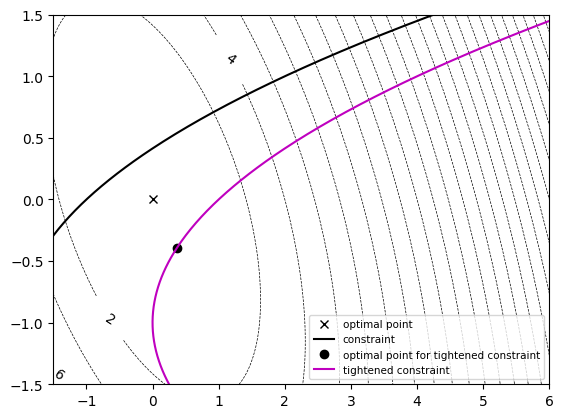

In [60]:
# Plot for objective function 
def plant_drawing(is_constraint,is_tight_constraint):
        delta = 0.01
        x = np.arange(-6.5, 6.5, delta)
        y = np.arange(-6.5, 6.5, delta)
        u = np.meshgrid(x, y)
        levels = np.linspace(0,50,26)

        CS1 = plt.contour(u[0],u[1],Benoit_Problem.Benoit_System_1(u),levels,colors='k',linestyles = "dashed",linewidths = 0.5)
        plt.clabel(CS1,inline=True)
        plt.axis((-1.5, 6.0, -1.5, 1.5))

        if is_constraint == True:
                plt.plot(0,0,'kx')
                
                # Plot for constraint
                uc0 = 1. + x**2 + 2.*x - 2.
                constraint1 = plt.plot(uc0,x,'k')

        if is_tight_constraint == True:
                # Plot for optimal value for optimization with tightened constraint
                plt.plot(0.36845785, -0.39299271,'ko')

                # Plot for tightened constraint
                uc0t = 1. + x ** 2 + 2. * x
                constraint2 = plt.plot(uc0t,x,'m')

# Plot trust region circle
def trustregion_drawing(r,input_0,input_1):
       
        d_trial_x = np.linspace(-r, r, 50)
        d_trial_ypos= []
        d_trial_yneg = []
        equations = lambda d: [r - np.linalg.norm(d),d[0] - j]
        for j in d_trial_x: 
                initial_guess = [0,0]
                d = fsolve(equations,initial_guess)
                d_trial_ypos.append(d[1])
                d_trial_yneg.append(-d[1])

        d_trial_ypos = np.array(d_trial_ypos)
        d_trial_yneg = np.array(d_trial_yneg)

        plt.plot(d_trial_x+input_0,d_trial_ypos+input_1,'k-',linewidth=0.5)
        plt.plot(d_trial_x+input_0,d_trial_yneg+input_1,'k-',linewidth=0.5)

def BRTO_Benoit_drawing(data):
        plt.figure()
        # Drawing for Benoit's Problem
        plant_drawing(is_constraint = False,is_tight_constraint = True)

        # Plot points for input observed
        plt.plot(data['input_0'],data['input_1'], 'ro')
        plt.plot(data['input_0'],data['input_1'],'b-',linewidth=1,label='_nolegend_')

        n_iter = len(data['input_0'])
        for i in range(n_iter):
                trustregion_drawing(data['r'][i],data['input_0'][i],data['input_1'][i])

def create_frame(fun_drawing,t,filename):
        fun_drawing
        plt.savefig(filename)
        plt.close()

def create_GIF(frame_duration,filenames,GIFname):
        # create a GIF from saved frames
        frame_duration = 1000
        with imageio.get_writer(GIFname, mode='I', duration=frame_duration) as writer:
                for filename in filenames:
                        image = imageio.imread(filename)
                        writer.append_data(image)
        # remove individual frame files
        for filename in filenames:
                os.remove(filename)

# plant_drawing(is_constraint=True,is_tight_constraint=False)
plant_drawing(is_constraint=True,is_tight_constraint=True)
plt.legend(["optimal point",
            "constraint",
            'optimal point for tightened constraint',
            'tightened constraint'],
                fontsize = 7.5)
plt.show()



## B. Without Uncertainty

In [61]:
###################################################################################
###########################______GP Initialization______###########################
###################################################################################
'''
Description:
    It does as follows:
    1. Collects samples
    2. Find optimal parameters
    3. Initializes GP.
Arguments:
    n_sample        : number of samples to collect your input for GP initialization
    u_0             : initial input u (center point of area where you collect  of samples)
    theta_0         : initial parameter values for model [parameters for obj fun, parameters for constraint 1, parameters for constraint 2,...]
    r               : initial radius of trust region
    plant_system    : array with elements of plant objective function and constraints
    model           : array with elements of model objective function and constraints
Returns:
    GP_m            : a Gaussian Process Model
'''
BRTO = BayesRTO.Bayesian_RTO()
np.random.seed(42)
random.seed(42)

n_sample            = 4
u_0                 = np.array([6.,0.])
theta_0             = np.array([1.5,1.,1.5,1.])
r                   = 0.5
plant_system        = [Benoit_Problem.Benoit_System_1,
                       Benoit_Problem.con1_system_tight]
model               = [Benoit_Problem.Benoit_Model_1,
                       Benoit_Problem.con1_Model]

theta,GP_m = BRTO.GP_Initialization(n_sample,u_0,theta_0,r,plant_system,model)

#######################################################################################
###########################______Bayesian Optimization______###########################
#######################################################################################
'''
'''
n_iter = 20
b = 0
# Dictionary for data collection
data = {}
data['input_0'] = [u_0[0]]
data['input_1'] = [u_0[1]]
data['plant output'] = [plant_system[0](u_0)]
data['plant constraint'] = [plant_system[1](u_0)]
data['model output'] = [model[0](theta,u_0,GP_m=GP_m)]
data['model constraint'] = [model[1](theta,u_0,GP_m=GP_m)]
data['r'] = [r]
# Parameters for GIF
filenames = []

for i in range(n_iter):
    # Create Frame
    t = i * 0.1
    filename = f'frame_{i:02d}.png'
    create_frame(BRTO_Benoit_drawing(data),t,filename)
    filenames.append(filename)

    # Bayesian Optimization
    d_new = BRTO.optimize_acquisition(r,u_0,theta,GP_m,b)     # New observation
    u_new = u_0 + d_new                                     # Collect data (u_new,modifier) on new observation
    modifier = BRTO.modifier_calc(theta,u_new)
    GP_m.add_sample(u_new,modifier)                         # Improve GP model using collected data on new observation
    u_0 = u_new                                             # For next iteration

    # Data Collection
    data['input_0'].append(u_new[0])
    data['input_1'].append(u_new[1])
    data['plant output'].append(plant_system[0](u_new))
    data['plant constraint'].append(plant_system[1](u_new))
    data['model output'].append(model[0](theta,u_new,GP_m=GP_m))
    data['model constraint'].append(model[1](theta,u_new,GP_m=GP_m))
    data['r'].append(r)

    if i == n_iter-1:
        # Create Last Frame
        t = n_iter * 0.1
        filename = f'frame_{n_iter:02d}.png'
        create_frame(BRTO_Benoit_drawing(data),t,filename)
        filenames.append(filename)

# Create GIF
frame_duration = 1000
GIFname = 'BRTO_Benoit.gif'
create_GIF(frame_duration,filenames,GIFname)

print(f"Final input: {data['input_0'][-1],data['input_1'][-1]}")

/Users/donggyulee/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Final input: (2.8828251543879955e+17, 2.930913799126326e+17)


### Graphical Illustration

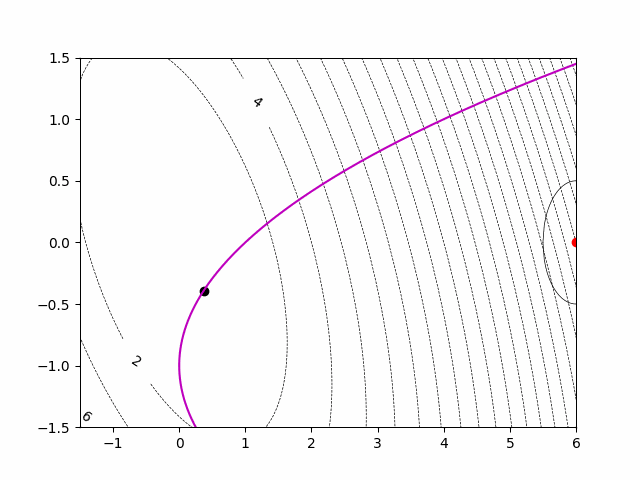

In [62]:
Image(filename='BRTO_Benoit.gif')

In [63]:
pd.DataFrame(data)

,input_0,input_1,plant output,plant constraint,model output,model constraint,r
0,6.000000e+00,0.000000e+00,3.600000e+01,5.000000e+00,3.668424e+01,4.656687e+00,0.5
1,5.702578e+00,-4.019202e-01,3.038895e+01,5.344878e+00,3.038895e+01,5.344878e+00,0.5
2,5.555420e+00,-8.797746e-01,2.674918e+01,5.540966e+00,2.674291e+01,5.542098e+00,0.5
3,5.466827e+00,-1.371863e+00,2.426847e+01,5.328545e+00,2.426846e+01,5.328548e+00,0.5
4,5.378470e+00,-1.863994e+00,2.237698e+01,4.631984e+00,2.237691e+01,4.632013e+00,0.5
5,4.955604e+00,-2.130799e+00,1.853892e+01,3.676898e+00,1.853862e+01,3.676940e+00,0.5
6,4.508816e+00,-2.355254e+00,1.525724e+01,2.672102e+00,1.524861e+01,2.675597e+00,0.5
7,4.033478e+00,-2.510348e+00,1.244536e+01,1.752328e+00,1.244418e+01,1.752429e+00,0.5
8,3.538780e+00,-2.437729e+00,9.838898e+00,1.471716e+00,9.840029e+00,1.471285e+00,0.5
9,3.080981e+00,-2.236681e+00,7.604014e+00,1.551600e+00,7.604660e+00,1.552154e+00,0.5


## Can find following informations

In [64]:
# 1. Input samples initially created by number n_sample(argument) and used to initialize GP
print(f"Initial Input Sample: \n {BRTO.input_sample}")

Initial Input Sample: 
 [[ 6.77035371 -0.21443403]
 [ 6.06189051  0.1455346 ]
 [ 5.62915731 -0.37081669]
 [ 6.42493319  0.20650066]]
